In [1]:
import sys
sys.path.insert(0, '../Triangulation/')
sys.path.insert(0, '../network_datasets')

In [2]:

from Triangulation import *

import torch
import torch.optim as optim
import struct



import torch.nn as nn

from torch.autograd import Variable
from math import atan2,pow,acos
from  Neural_network import *

from torch.autograd.function import Function
from point_coordinates_regression import *



import matplotlib.cm as cm
import matplotlib.colors as colors




%matplotlib qt

In [3]:
def get_grid_qualities(XX,YY,inner_points):
    qualities=np.empty([len(XX[0,:]),len(YY[:,0])])
    for index_x,x in enumerate(XX[0,:]):
        for index_y,y in enumerate(YY[:,0]):
            quality=np.min(np.array([np.linalg.norm(point-np.array([x,y]),2) for point in inner_points]))
            qualities[index_x][index_y]=quality
    return qualities

def plot_contour(contour):    
    plot_coords=np.vstack([contour,contour[0]])
    (s,t)=zip(*plot_coords)
    plt.axis('off')
    plt.plot(s,t,linewidth=4,markersize=18,marker='o',c='black')


def get_grid_qualities_with_penalty(XX,YY,inner_points,contour):
    qualities=np.empty([len(XX[0,:]),len(YY[:,0])])
    for index_x,x in enumerate(XX[0,:]):
        for index_y,y in enumerate(YY[:,0]):
            quality=np.min(np.array([np.linalg.norm(point-np.array([x,y]),2) for point in inner_points]))
            for contour_point in contour:
                if np.linalg.norm(np.array([x,y])-contour_point)<0.2:
                    quality=2
                
            qualities[index_x][index_y]=quality
    return qualities


def get_grid_qualities_with_penalty_midpoint_included(XX,YY,inner_points,contour):
    qualities=np.empty([len(XX[0,:]),len(YY[:,0])])
    for index_x,x in enumerate(XX[0,:]):
        for index_y,y in enumerate(YY[:,0]):
            quality=np.min(np.array([np.linalg.norm(point-np.array([x,y]),2) for point in inner_points]))
            for index,contour_point in enumerate(contour):
                if np.linalg.norm(np.array([x,y])-contour_point)<0.13:
                    quality=1.3
                mid_point=0.5*(contour[index]+contour[(index+1)%len(contour)])
                if np.linalg.norm(np.array([x,y])-mid_point)<0.13:
                    quality=1.3


                
            qualities[index_x][index_y]=quality
    return qualities


def plot_grid_qualities(contour,grid_qualities,grid_points,inner_points):
    plt.clf()
    B=list(grid_qualities.flatten())
    cs = plt.scatter(grid_points[:,0],grid_points[:,1],c=B,cmap=cm.RdYlGn_r,vmin=min(grid_qualities.flatten()),vmax=max(grid_qualities.flatten()),s=4)
    plot_contour(contour)
    plot_contour(contour)
    plt.scatter(inner_points[:,0],inner_points[:,1],marker='o',c='b',label='Point location')
    plt.colorbar(cs)
    plt.legend()
    plt.show()
    

def save_grid_regression_NN(filename,net):
    path=os.path.join('../network_datasets/grid_NN',filename)

    with open(path,'wb') as output:
        pickle.dump(net,output)
        
def load_grid_regression_NN(filename):
    path=os.path.join('../network_datasets/grid_NN',filename)
        
    with open(path,'rb') as input:
        net=pickle.load(input)        
    net.eval()
    return net
    


def save_grid_qualities(filename,qualities):
    path=os.path.join('../polygon_datasets/grid_qualities/',filename)

    with open(path,'wb') as output:
        pickle.dump(qualities,output)
        
def load_grid_qualities(filename):
    path=os.path.join('../polygon_datasets/grid_qualities/',filename)
        
    with open(path,'rb') as input:
        grid_qualities=pickle.load(input)        
    return grid_qualities
    
    

def select_points(contour,grid_points,grid_qualities,nb_of_points,two_ring=True):
    
    selected_points=[]
    
    grid_qualities_duplicate=grid_qualities.flatten()
    label_added=False
    for i in range(nb_of_points):
        
        minimum_index=np.argmin(grid_qualities_duplicate)
        surrounding_points_index=np.array([minimum_index+1,minimum_index-1,minimum_index+nb_of_grid_points
                        ,minimum_index-nb_of_grid_points,minimum_index-nb_of_grid_points+1,minimum_index-nb_of_grid_points-1,
                        minimum_index+nb_of_grid_points+1,minimum_index+nb_of_grid_points-1])

    
        surrounding_points_index_2_ring=np.array([minimum_index+2,minimum_index-2,
                        minimum_index+2*nb_of_grid_points,
                        minimum_index+2*nb_of_grid_points+2,minimum_index+2*nb_of_grid_points-2,
                        minimum_index+2*nb_of_grid_points+1,minimum_index+2*nb_of_grid_points-1,                      
                                              
                                              
                        minimum_index-2*nb_of_grid_points,
                        minimum_index-2*nb_of_grid_points+1,minimum_index-2*nb_of_grid_points-1, 
                        minimum_index-2*nb_of_grid_points+2, minimum_index-2*nb_of_grid_points-2 ,
                                              
                        minimum_index+2,
                        minimum_index-2 ,
                        minimum_index+nb_of_grid_points+2,
                        minimum_index+nb_of_grid_points-2,
                                              
                        minimum_index-nb_of_grid_points+2,
                        minimum_index-nb_of_grid_points-2,


                                                                
                ])
        surrounding_points=grid_points[np.asarray(surrounding_points_index)]
        surrounding_points_2_ring=grid_points[np.asarray(surrounding_points_index_2_ring)]
        point_maximum=grid_points[minimum_index]
        #if not label_added:
         #   plt.scatter(point_maximum[0],point_maximum[1],marker='d',s=30,c='y',label='Predictions')
          #  label_added=True
        #plt.scatter(point_maximum[0],point_maximum[1],marker='d',s=30,c='y')
        selected_points.append(point_maximum)
        grid_qualities_duplicate[minimum_index]=100
        if two_ring==True:
            grid_qualities_duplicate[np.asarray(surrounding_points_index)]=100
    return np.array(selected_points)


    
    
    



In [4]:
nb_of_grid_points=10

X=np.linspace(-1.3,1.3,nb_of_grid_points)
Y=np.linspace(-1.3,1.3,nb_of_grid_points)
XX,YY=np.meshgrid(X,Y)

grid_points=np.array([[x,y] for x in X for y in Y])

nb_of_edges=8
nb_of_points=4


In [5]:
polygons_initial=load_dataset(str(nb_of_edges)+'_polygons.pkl')
point_coordinates_initial=load_dataset(str(nb_of_edges)+'_point_coordinates_del.pkl')
number_of_insertion_points=load_dataset(str(nb_of_edges)+'_nb_of_points_del.pkl')

In [6]:
polygons_reshaped,point_coordinates=reshape_data(polygons_initial,point_coordinates_initial,number_of_insertion_points,nb_of_points)


if nb_of_points==1:
    # adding additional data to the two point dataset
    additional_polygons_with_target_edge_length=load_dataset('8_polygons_with_target_edgelengths_2_points.pkl')
    polygons_reshaped=np.vstack([polygons_reshaped,additional_polygons_with_target_edge_length])
    additional_point_coordinates=load_dataset('8_polygons_other_coordinates_2_points.pkl')
    point_coordinates=np.vstack([point_coordinates,additional_point_coordinates.reshape(len(additional_point_coordinates),1,4)])

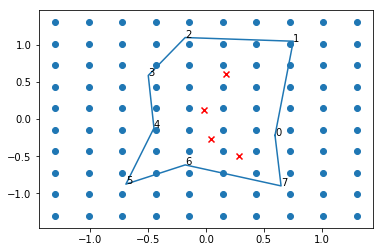

In [7]:
plt.clf()

contour=np.delete(polygons_reshaped[85],2*nb_of_edges).reshape(nb_of_edges,2)
plot_contour(contour)

inner_points=np.array(point_coordinates[85].reshape(nb_of_points,2))
plt.scatter(inner_points[:,0],inner_points[:,1],marker='x',color='r')


plt.scatter(XX,YY)

In [106]:
# Compute grid qualities 

grid_qualities=get_grid_qualities_with_penalty_midpoint_included(XX,YY,inner_points,contour)

In [107]:
# Plotting grid

plot_grid_qualities(contour,grid_qualities,grid_points,inner_points)


In [108]:
label_added=False

grid_qualities_duplicate=grid_qualities.flatten()

predicted_points=[]
for i in range(nb_of_points):
    minimum_index=np.argmin(grid_qualities_duplicate)
    surrounding_points_index=np.array([minimum_index+1,minimum_index-1,minimum_index+nb_of_grid_points
                        ,minimum_index-nb_of_grid_points,minimum_index-nb_of_grid_points+1,minimum_index-nb_of_grid_points-1,
                        minimum_index+nb_of_grid_points+1,minimum_index+nb_of_grid_points-1])

    
    surrounding_points_index_2_ring=np.array([minimum_index+2,minimum_index-2,
                        minimum_index+2*nb_of_grid_points,
                        minimum_index+2*nb_of_grid_points+2,minimum_index+2*nb_of_grid_points-2,
                        minimum_index+2*nb_of_grid_points+1,minimum_index+2*nb_of_grid_points-1,                      
                                              
                                              
                        minimum_index-2*nb_of_grid_points,
                        minimum_index-2*nb_of_grid_points+1,minimum_index-2*nb_of_grid_points-1, 
                        minimum_index-2*nb_of_grid_points+2, minimum_index-2*nb_of_grid_points-2 ,
                                              
                        minimum_index+2,
                        minimum_index-2 ,
                        minimum_index+nb_of_grid_points+2,
                        minimum_index+nb_of_grid_points-2,
                                              
                        minimum_index-nb_of_grid_points+2,
                        minimum_index-nb_of_grid_points-2,


                                                                
                ])
    
    surrounding_points=grid_points[np.asarray(surrounding_points_index)]
    surrounding_points_2_ring=grid_points[np.asarray(surrounding_points_index_2_ring)]
    point_maximum=grid_points[minimum_index]
    if not label_added:
        plt.scatter(inner_points[:,0],inner_points[:,1],marker='o',color='b',label='Point location')
        plt.scatter(point_maximum[0],point_maximum[1],marker='d',s=30,c='y',label='Predictions')
        #plt.scatter(surrounding_points[:,0],surrounding_points[:,1],marker='x',s=23,c='r',label='Excluded points')

        label_added=True

    plt.scatter(point_maximum[0],point_maximum[1],marker='d',s=30,c='y')
    #plt.scatter(surrounding_points[:,0],surrounding_points[:,1],marker='x',s=23,c='r')
    #plt.scatter(surrounding_points_2_ring[:,0],surrounding_points_2_ring[:,1],marker='d',s=34)
    predicted_points.append(point_maximum)
    grid_qualities_duplicate[minimum_index]=100
    grid_qualities_duplicate[np.asarray(surrounding_points_index)]=100
    #grid_qualities_duplicate[np.asarray(surrounding_points_index_2_ring)]=100
plot_contour(contour)
plt.legend()


In [109]:
# Including the grid points to the polygon set

polygons_reshaped_with_grid_points=[]
for polygon in polygons_reshaped:
    for index in range(len(grid_points)):
        polygons_reshaped_with_grid_points.append( np.hstack([polygon,grid_points[index]]))
polygons_reshaped_with_grid_points=np.array(polygons_reshaped_with_grid_points)

In [110]:
# For every polygon obtain grid qualities

polygons_grid_qualities=[]
for index,points in enumerate(point_coordinates):
    inner_points=points.reshape(nb_of_points,2)
    contour=np.delete(polygons_reshaped[index],2*nb_of_edges).reshape(nb_of_edges,2)
    grid_qualities=get_grid_qualities_with_penalty_midpoint_included(XX,YY,inner_points,contour)

    polygons_grid_qualities.append(grid_qualities)
    
    

polygons_grid_qualities=np.array(polygons_grid_qualities)

In [38]:
# reshape polygons grid qualities
#save_dataset('grid_qualities_with_penalty_8_7.pkl',polygons_grid_qualities)
#save_dataset('grid_qualities_with_penalty_and_midpoint_8_5_2nd.pkl',polygons_grid_qualities)
#save_dataset('grid_qualities_with_penalty_and_midpoint_8_3_2nd.pkl',polygons_grid_qualities)

#save_dataset('grid_qualities_with_penalty_and_midpoint_8_7.pkl',polygons_grid_qualities)
#save_dataset('grid_qualities_with_penalty_and_midpoint_8_7_2nd.pkl',polygons_grid_qualities)
#save_dataset('grid_qualities_with_penalty_and_midpoint_8_7_3rd.pkl',polygons_grid_qualities)

save_grid_qualities('grid_qualities_with_penalty_and_midpoint_'+str(nb_of_edges)+'_'+str(nb_of_points)+'_'+str(nb_of_grid_points),polygons_grid_qualities)

polygons_grid_qualities=load_grid_qualities('grid_qualities_with_penalty_and_midpoint_'+str(nb_of_edges)+'_'+str(nb_of_points)+'_'+str(nb_of_grid_points))
polygons_grid_qualities_reshaped=polygons_grid_qualities.reshape(len(polygons_reshaped)*len(grid_points),1,1)


In [39]:
# Shuffle the data

polygons_reshaped_with_grid_points,polygons_grid_qualities_reshaped=unison_shuffled_copies(polygons_reshaped_with_grid_points,polygons_grid_qualities_reshaped)

In [40]:
# 80/20 training/test data ratio

nb_of_test_data=int(len(polygons_reshaped_with_grid_points)*0.2)
nb_of_training_data=int(len(polygons_reshaped_with_grid_points)-nb_of_test_data)
nb_of_test_data,nb_of_training_data


(343940, 1375760)

In [49]:
# Setting up the variables

x_tensor=torch.from_numpy(polygons_reshaped_with_grid_points[:nb_of_training_data]).type(torch.FloatTensor)
x_tensor_test=torch.from_numpy(polygons_reshaped_with_grid_points[nb_of_training_data:]).type(torch.FloatTensor)
x_variable,x_variable_test=Variable(x_tensor),Variable(x_tensor_test)

y_tensor=torch.from_numpy(polygons_grid_qualities_reshaped[:nb_of_training_data]).type(torch.FloatTensor)
y_tensor_test=torch.from_numpy(polygons_grid_qualities_reshaped[nb_of_training_data:]).type(torch.FloatTensor)

y_variable,y_variable_test=Variable(y_tensor),Variable(y_tensor_test)





In [50]:
my_net=Net(x_variable.size()[1],y_variable.size()[2],nb_of_hidden_layers=2, nb_of_hidden_nodes=40,batch_normalization=True)
torch.cuda.empty_cache()
print("Training data length:",x_variable_test.size()[1],y_variable.size()[2])
x_variable.size()[0]

Training data length: 19 1


1375760

In [51]:
optimizer = torch.optim.Adam(my_net.parameters(), lr=1e-4,weight_decay=0.2)
loss_func =torch.nn.MSELoss(size_average=False) 


In [ ]:

if  torch.cuda.is_available():
    loss_func.cuda()
        
    x_variable , y_variable=x_variable.cuda(), y_variable.cuda()
    x_variable_test,y_variable_test= Variable(x_tensor_test.cuda(),volatile=True),Variable(y_tensor_test.cuda(),volatile=True)

    print("cuda activated")
    
    

In [52]:
batch_size=int(x_variable.size()[0])
nb_of_epochs=13000 
#my_net.cuda()
my_net.cpu()

# Train the network #
my_net.train()
for t in range(nb_of_epochs):
    sum_loss=0
    for b in range(0,x_variable.size(0),batch_size):
        out = my_net(x_variable.narrow(0,b,batch_size))                 # input x and predict based on x
        loss= loss_func(out, y_variable.narrow(0,b,batch_size))     # must be (1. nn output, 2. target), the target label is NOT one-hotted
        
        sum_loss+=loss.data[0]

        
        optimizer.zero_grad()   # clear gradients for next train
        loss.backward()         # backpropagation, compute gradients
        optimizer.step()        # apply gradients
        del loss
        del out
    if t%10==0: 
        my_net.eval()
        out_test=my_net(x_variable_test)   
        test_loss=loss_func(out_test,y_variable_test)
        print("Epoch:",t,"Training Loss:",sum_loss/(x_variable.size(0)),test_loss.data[0]/(x_variable_test.size(0)))
        my_net.train()


Epoch: 0 Training Loss: 1.7470334578705589 1.5022249520265163
Epoch: 10 Training Loss: 1.708953596557539 1.7005751366517416
Epoch: 20 Training Loss: 1.6721977307088445 1.6650484096063267


KeyboardInterrupt: 

In [56]:

save_grid_regression_NN(str(nb_of_edges)+'_'+str(nb_of_points)+'_'+str(nb_of_grid_points)+'_grid_regression_NN.pkl',my_net)
my_net=load_grid_regression_NN(str(nb_of_edges)+'_'+str(nb_of_points)+'_'+str(nb_of_grid_points)+'_grid_regression_NN.pkl')

9 0.2801987312584695 -0.3139146700948871 0
10 0.0733570983870202 0.2669931265260642 0
11 -0.5730079290211024 0.2383582647085348 0
12 0.2598681079833305 0.3520294539554166 0
9 0.2801987312584695 -0.3139146700948871 0
10 0.0733570983870202 0.2669931265260642 0
11 -0.5730079290211024 0.2383582647085348 0
12 0.2598681079833305 0.3520294539554166 0
9 0.2801987312584695 -0.3139146700948871 0
10 0.07335709838702018 0.2669931265260643 0
11 -0.5730079290211024 0.2383582647085348 0
12 0.2598681079833305 0.3520294539554167 0
9 -0.009870502202795145 0.2282226057808651 0
10 -0.1335517519003125 -0.1855106365142342 0
11 -0.5212002146609404 -0.3720394117154029 0
12 -0.280771900588821 -0.4946296207795039 0
13 -0.3322431197426103 0.08484856012060213 0
14 -0.1600713671085479 0.5886559117637151 0
15 0.2427069751106491 0.5761617572591955 0
16 0.1892388951710644 -0.3267065517918839 0
17 -0.3619934250605188 -0.1693714110543783 0
18 -0.005670458978193939 -0.4354274013611063 0
9 -0.06140662749970294 0.05347074

IndexError: index 102 is out of bounds for axis 0 with size 100

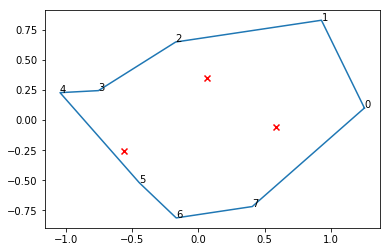

In [96]:
# Plotting the random contour using the FNN network  by predictiong the grid values
plt.clf()
for i in range(1000):
    random_contour=apply_procrustes(generate_contour(nb_of_edges))
    random_nb_of_points,random_point_coordinated_delaunay=get_extrapoints_target_length(random_contour,1,algorithm='del2d')
    if random_nb_of_points==nb_of_points:
          break
random_contour_reshaped=random_contour.reshape(1,2*nb_of_edges)
random_contour_with_target=np.hstack([random_contour_reshaped,[[1]]])

plot_contour(random_contour)
random_point_coordinated_delaunay=np.array(random_point_coordinated_delaunay)
random_point_coordinated_delaunay.reshape(nb_of_points,2)
plt.scatter(random_point_coordinated_delaunay[:,0],random_point_coordinated_delaunay[:,1],marker='x',c='r',label='Point location')





my_net=my_net.cpu()
my_net.eval()
random_grid_qualities=[]
for point in grid_points:
    random_contour_with_target_and_grid_point=np.hstack([random_contour_with_target,point.reshape(1,2)])
    random_contour_with_target_and_grid_point=Variable(torch.from_numpy(random_contour_with_target_and_grid_point))
    random_contour_with_target_and_grid_point=random_contour_with_target_and_grid_point.expand(1000,2*nb_of_edges+1+2).type(torch.FloatTensor)
    random_point_quality=my_net(random_contour_with_target_and_grid_point)
    random_point_quality=random_point_quality.data[0]
    random_point_quality=random_point_quality.numpy()

    #print(random_point_quality)
    random_grid_qualities.append(random_point_quality)

random_grid_qualities=np.array(random_grid_qualities)




label_added=False

grid_qualities_duplicate=random_grid_qualities.flatten()

predicted_points=[]
for i in range(nb_of_points):
    minimum_index=np.argmin(grid_qualities_duplicate)
    surrounding_points_index=np.array([minimum_index+1,minimum_index-1,minimum_index+nb_of_grid_points
                        ,minimum_index-nb_of_grid_points,minimum_index-nb_of_grid_points+1,minimum_index-nb_of_grid_points-1,
                        minimum_index+nb_of_grid_points+1,minimum_index+nb_of_grid_points-1])

    
    surrounding_points_index_2_ring=np.array([minimum_index+2,minimum_index-2,
                        minimum_index+2*nb_of_grid_points,
                        minimum_index+2*nb_of_grid_points+2,minimum_index+2*nb_of_grid_points-2,
                        minimum_index+2*nb_of_grid_points+1,minimum_index+2*nb_of_grid_points-1,                      
                                              
                                              
                        minimum_index-2*nb_of_grid_points,
                        minimum_index-2*nb_of_grid_points+1,minimum_index-2*nb_of_grid_points-1, 
                        minimum_index-2*nb_of_grid_points+2, minimum_index-2*nb_of_grid_points-2 ,
                                              
                        minimum_index+2,
                        minimum_index-2 ,
                        minimum_index+nb_of_grid_points+2,
                        minimum_index+nb_of_grid_points-2,
                                              
                        minimum_index-nb_of_grid_points+2,
                        minimum_index-nb_of_grid_points-2,


                                                                
                ])
    
    surrounding_points=grid_points[np.asarray(surrounding_points_index)]
    surrounding_points_2_ring=grid_points[np.asarray(surrounding_points_index_2_ring)]
    point_maximum=grid_points[minimum_index]
    if not label_added:
        plt.scatter(point_maximum[0],point_maximum[1],marker='d',s=30,c='y',label='Predictions')
        label_added=True
    plt.scatter(point_maximum[0],point_maximum[1],marker='d',s=30,c='y')
    #plt.scatter(surrounding_points[:,0],surrounding_points[:,1],marker='d',s=34)
    #plt.scatter(surrounding_points_2_ring[:,0],surrounding_points_2_ring[:,1],marker='d',s=34)
    predicted_points.append(point_maximum)
    grid_qualities_duplicate[minimum_index]=100
    grid_qualities_duplicate[np.asarray(surrounding_points_index)]=100
    #grid_qualities_duplicate[np.asarray(surrounding_points_index_2_ring)]=100
plot_contour(random_contour)
plt.legend()



    

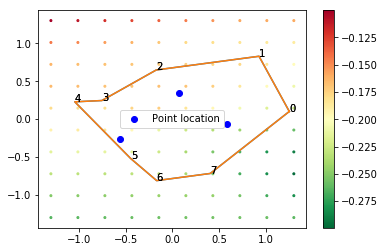

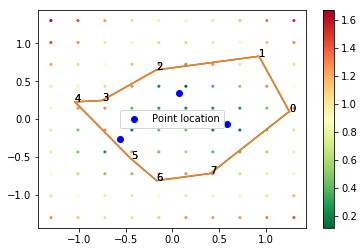

IndexError: index 102 is out of bounds for axis 0 with size 100

In [97]:
plot_grid_qualities(random_contour,random_grid_qualities,grid_points,random_point_coordinated_delaunay)
grid_qualities=get_grid_qualities_with_penalty_midpoint_included(XX,YY,random_point_coordinated_delaunay,random_contour)
plot_grid_qualities(random_contour,grid_qualities,grid_points,random_point_coordinated_delaunay)
selected_points=select_points(random_contour,grid_points,grid_qualities,nb_of_points,two_ring=True)
random_selected_points=select_points(random_contour,grid_points,random_grid_qualities,5,two_ring=True)

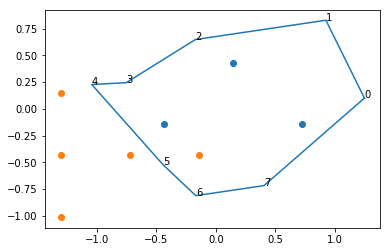

In [98]:
plt.scatter(selected_points[:,0],selected_points[:,1])
plt.scatter(random_selected_points[:,0],random_selected_points[:,1])
plot_contour(random_contour)

In [69]:
# Mean error for grid point regression
my_net=my_net.cpu()
my_net.eval()
regression_errors=[]
for j in range(300):
    for i in range(1000):
        random_contour=apply_procrustes(generate_contour(nb_of_edges))
        random_nb_of_points,random_point_coordinated_delaunay=get_extrapoints_target_length(random_contour,1,algorithm='del2d')
        if random_nb_of_points==nb_of_points:
              break
    random_contour_reshaped=random_contour.reshape(1,2*nb_of_edges)
    random_contour_with_target=np.hstack([random_contour_reshaped,[[1]]])

    random_point_coordinated_delaunay=np.array(random_point_coordinated_delaunay)
    random_point_coordinated_delaunay.reshape(nb_of_points,2)
    random_grid_qualities=[]
    for point in grid_points:
        random_contour_with_target_and_grid_point=np.hstack([random_contour_with_target,point.reshape(1,2)])
        random_contour_with_target_and_grid_point=Variable(torch.from_numpy(random_contour_with_target_and_grid_point))
        random_contour_with_target_and_grid_point=random_contour_with_target_and_grid_point.expand(1000,2*nb_of_edges+1+2).type(torch.FloatTensor)
        random_point_quality=my_net(random_contour_with_target_and_grid_point)
        random_point_quality=random_point_quality.data[0]
        random_point_quality=random_point_quality.numpy()

        random_grid_qualities.append(random_point_quality)

    random_grid_qualities=np.array(random_grid_qualities)

    grid_qualities_duplicate=random_grid_qualities.flatten()
    predicted_points=[]
    for i in range(nb_of_points):
        minimum_index=np.argmin(grid_qualities_duplicate)
        surrounding_points_index=np.array([minimum_index+1,minimum_index-1,minimum_index+nb_of_grid_points
                        ,minimum_index-nb_of_grid_points,minimum_index-nb_of_grid_points+1,minimum_index-nb_of_grid_points-1,
                        minimum_index+nb_of_grid_points+1,minimum_index+nb_of_grid_points-1])

    
        surrounding_points_index_2_ring=np.array([minimum_index+2,minimum_index-2,
                        minimum_index+2*nb_of_grid_points,
                        minimum_index+2*nb_of_grid_points+2,minimum_index+2*nb_of_grid_points-2,
                        minimum_index+2*nb_of_grid_points+1,minimum_index+2*nb_of_grid_points-1,                      
                                              
                                              
                        minimum_index-2*nb_of_grid_points,
                        minimum_index-2*nb_of_grid_points+1,minimum_index-2*nb_of_grid_points-1, 
                        minimum_index-2*nb_of_grid_points+2, minimum_index-2*nb_of_grid_points-2 ,
                                              
                        minimum_index+2,
                        minimum_index-2 ,
                        minimum_index+nb_of_grid_points+2,
                        minimum_index+nb_of_grid_points-2,
                                              
                        minimum_index-nb_of_grid_points+2,
                        minimum_index-nb_of_grid_points-2,


                                                                
                ])
        surrounding_points=grid_points[np.asarray(surrounding_points_index)]
        #surrounding_points_2_ring=grid_points[np.asarray(surrounding_points_index_2_ring)]
        point_maximum=grid_points[minimum_index]
        predicted_points.append(point_maximum)
        grid_qualities_duplicate[minimum_index]=100
        grid_qualities_duplicate[np.asarray(surrounding_points_index)]=100
        #grid_qualities_duplicate[np.asarray(surrounding_points_index_2_ring)]=100
    predicted_points=np.array(predicted_points)
    error=regression_error(real_points=random_point_coordinated_delaunay,prediction_points=predicted_points,nb_of_interior_points=nb_of_points)
    regression_errors.append(error)
regression_errors=np.array(regression_errors)
regression_errors.mean()

9 -0.1325230227979942 -0.1113119781471219 0
10 0.1870311587414671 0.1320613510536848 0
11 0.2430825926549004 -0.2015125300419283 0
12 -0.1870221422623293 0.3588414018198303 0
13 0.1160025918551997 -0.472194324452856 0
14 0.4260926810706907 -0.007541827005685564 0
15 0.4243949683231603 0.2879965934357975 0
16 0.3830221464609553 -0.4751035168631013 0
17 -0.3016847206688034 -0.4919250889195727 0
18 0.5470056447017133 0.1886188831836921 0
19 0.4788700055229924 -0.2749845195317459 0
20 0.3004821494438263 0.475393462860142 0
9 0.1677124672175212 -0.2919193539275222 0
10 0.2345647466499743 0.04548994276557528 0
11 0.3000462336409215 0.4113679088309251 0
12 -0.3707145912217241 -0.2519067308719834 0
13 -0.09737953129284038 0.0514116702798996 0
14 0.2062125904527764 -0.5945657596580761 0
15 -0.008007243097457982 -0.3878790395372833 0
16 -0.2362189745121975 0.4461601961475239 0
17 0.4499033031694366 0.1876759050751443 0
18 0.3537579942451536 -0.3420711069548193 0
19 0.4710159061928878 -0.11774552

IndexError: index 105 is out of bounds for axis 0 with size 100

#random_point_coordinated_delaunay=sort_points(random_point_coordinated_delaunay.reshape(1,5,2),5).reshape(5,2)
point_polygon=sort_points(random_point_coordinated_delaunay.reshape(1,nb_of_points,2),nb_of_points).reshape(nb_of_points,2)
plot_contour(point_polygon)
prediction_point_polygon=sort_points(predicted_points.reshape(1,nb_of_points,2),nb_of_points).reshape(nb_of_points,2)
plot_contour(prediction_point_polygon)


procrusted_predicted_points=apply_procrustes(prediction_point_polygon,point_polygon)
plot_contour(procrusted_predicted_points)

In [151]:
sort_points(random_point_coordinated_delaunay.reshape(1,3,2),3).reshape(3,2)

ValueError: cannot reshape array of size 10 into shape (1,3,2)

In [ ]:
sort_points(predicted_points.reshape(1,5,2),5).reshape(5,2)

In [ ]:
plot_contour(sort_points(random_point_coordinated_delaunay.reshape(1,5,2),5).reshape(5,2))

In [80]:
from Triangulation_with_points import*

In [81]:
predicted_points=np.array(predicted_points)

In [82]:
random_contour_with_points=np.vstack([random_contour,predicted_points])

In [83]:
quality,_=quality_matrix(random_contour,predicted_points)


[[[[ 1.08025711 -0.13262856]
   [ 0.7122006   0.65895175]
   [ 1.08025711 -0.13262856]]

  [[ 1.08025711 -0.13262856]
   [ 0.7122006   0.65895175]
   [ 0.7122006   0.65895175]]

  [[ 1.08025711 -0.13262856]
   [ 0.7122006   0.65895175]
   [-0.21668611  1.0756888 ]]

  [[ 1.08025711 -0.13262856]
   [ 0.7122006   0.65895175]
   [-0.71776767  0.86407888]]

  [[ 1.08025711 -0.13262856]
   [ 0.7122006   0.65895175]
   [-0.69482836 -0.01809001]]

  [[ 1.08025711 -0.13262856]
   [ 0.7122006   0.65895175]
   [-0.395223   -0.77791156]]

  [[ 1.08025711 -0.13262856]
   [ 0.7122006   0.65895175]
   [-0.01656598 -1.11731672]]

  [[ 1.08025711 -0.13262856]
   [ 0.7122006   0.65895175]
   [ 0.24861342 -0.55277258]]

  [[ 1.08025711 -0.13262856]
   [ 0.7122006   0.65895175]
   [-1.3        -1.3       ]]

  [[ 1.08025711 -0.13262856]
   [ 0.7122006   0.65895175]
   [-0.72222222 -1.3       ]]]


 [[[ 0.7122006   0.65895175]
   [-0.21668611  1.0756888 ]
   [ 1.08025711 -0.13262856]]

  [[ 0.7122006   0.

In [85]:
ordered_matrix=order_quality_matrix(quality,random_contour,random_contour_with_points,check_for_equal=True)


[[0.61933637 0.5594044  0.41069865 0.40799835 0.07345705 0.
  0.         0.         0.         0.        ]
 [0.61933637 0.29677472 0.24842118 0.24842118 0.03585884 0.
  0.         0.         0.         0.        ]
 [0.61933637 0.29677472 0.24842118 0.2014109  0.03585884 0.
  0.         0.         0.         0.        ]
 [0.61933637 0.430541   0.43037617 0.24842118 0.2014109  0.07345705
  0.         0.         0.         0.        ]
 [0.61933637 0.5188278  0.41069865 0.41069865 0.24842118 0.2014109
  0.         0.         0.         0.        ]
 [0.61933637 0.5188278  0.41069865 0.39770284 0.24842118 0.2014109
  0.         0.         0.         0.        ]
 [0.61933637 0.61933637 0.43037617 0.41069865 0.40799835 0.03585884
  0.         0.         0.         0.        ]
 [0.61933637 0.5594044  0.41069865 0.40799835 0.07345705 0.
  0.         0.         0.         0.        ]]
[(0.61933637, 1), (0.5594044, 1), (0.41069865, 1), (0.40799835, 1), (0.073457055, 1)]
checked (7, 0)
[(0.61933637

initial set edges: {(0, 1), (1, 2), (6, 7), (7, 0), (4, 5), (5, 6), (2, 3), (3, 4)}
meshing polygon:  [[ 1.08025711 -0.13262856]
 [ 0.7122006   0.65895175]
 [-0.21668611  1.0756888 ]
 [-0.71776767  0.86407888]
 [-0.69482836 -0.01809001]
 [-0.395223   -0.77791156]
 [-0.01656598 -1.11731672]
 [ 0.24861342 -0.55277258]]  with inner points : [[-1.3        -1.3       ]
 [-0.72222222 -1.3       ]]
Edge: (7, 0) targeting: 1
(7, 0, 1)
Vertex locked: 0
edges inserted: (7, 1)
set of interior edges updated: {(7, 1)}
set of edges updated: {(0, 1), (1, 2), (6, 7), (7, 0), (7, 1), (4, 5), (5, 6), (2, 3), (3, 4)}
element inserted: (7, 0, 1)
Spotted edges linked with point:  (7, 1)   (0, 1)
Edge: (6, 7) targeting: 5
(6, 7, 5)
Vertex locked: 6
edges inserted: (7, 5)
set of interior edges updated: {(7, 5), (7, 1)}
set of edges updated: {(0, 1), (1, 2), (6, 7), (7, 0), (7, 1), (4, 5), (5, 6), (7, 5), (2, 3), (3, 4)}
element inserted: (6, 7, 5)
Spotted edges linked with point:  (6, 5)   (7, 5)
Edge: (5, 6

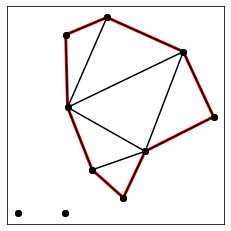

In [86]:
triangulate(random_contour,predicted_points,ordered_matrix,recursive=True)


In [87]:
predicted_points=sort_points(predicted_points,1)

../Triangulation\Triangulation_with_points.py:166: RuntimeWarning: invalid value encountered in double_scalars
  cosx=dot_product(v,w)/(length(v)*length(w))


In [90]:
predicted_points=predicted_points.reshape(2,2)

In [91]:
predicted_points

array([[-1.3       , -1.3       ],
       [-0.72222222, -1.3       ]])

9 -0.07191269356609696 0.367940721312876 0
10 0.3859187515789989 -0.3250556577384375 0
9 0.1913226056784143 -0.2582559448100765 0
10 0.01134890475862032 0.3715956661167584 0
11 0.3261697280999462 0.1218695589040026 0
12 0.386043591047983 0.4361077530396368 0
13 0.5529422570520219 -0.1301825545752747 0
14 -0.6434641310945746 -0.1525267223493617 0
15 -0.3545436886175291 -0.2588663125832799 0
16 -0.03040726551582132 0.04150555538141666 0
9 -0.07191269356609696 0.367940721312876 0
10 0.3859187515789989 -0.3250556577384375 0
9 -0.07191269356609698 0.367940721312876 0
10 0.3859187515789989 -0.3250556577384375 0
9 -0.07191269356609696 0.367940721312876 0
10 0.3859187515789989 -0.3250556577384375 0
9 0.2650317045854107 0.2413798748975684 0
10 -0.1848191084807428 0.1687725978036879 0
11 -0.5420107689299011 -0.0386032351933554 0
12 0.0008997325770745253 0.05397440013343367 0
13 -0.4971123075594208 -0.4090522441993959 0
14 0.3139523778826836 -0.2087861379912547 0
15 0.02561122528873776 0.31871590

[[[[ 1.04624993  0.05572893]
   [ 0.40388873  0.35460675]
   [ 1.04624993  0.05572893]]

  [[ 1.04624993  0.05572893]
   [ 0.40388873  0.35460675]
   [ 0.40388873  0.35460675]]

  [[ 1.04624993  0.05572893]
   [ 0.40388873  0.35460675]
   [-0.27599794  1.19920629]]

  [[ 1.04624993  0.05572893]
   [ 0.40388873  0.35460675]
   [-0.40399952  0.35870055]]

  [[ 1.04624993  0.05572893]
   [ 0.40388873  0.35460675]
   [-0.43381749  0.09673643]]

  [[ 1.04624993  0.05572893]
   [ 0.40388873  0.35460675]
   [-0.75863749 -0.53308155]]

  [[ 1.04624993  0.05572893]
   [ 0.40388873  0.35460675]
   [-0.43632664 -1.18752833]]

  [[ 1.04624993  0.05572893]
   [ 0.40388873  0.35460675]
   [ 0.85864041 -0.34436907]]

  [[ 1.04624993  0.05572893]
   [ 0.40388873  0.35460675]
   [-1.3        -1.3       ]]

  [[ 1.04624993  0.05572893]
   [ 0.40388873  0.35460675]
   [-0.72222222 -1.3       ]]

  [[ 1.04624993  0.05572893]
   [ 0.40388873  0.35460675]
   [-0.14444444 -1.3       ]]]


 [[[ 0.40388873  0.

[3, 4, 9]
[3, 4, 10]
Invalid triangulation 3 4 10
[4, 5, 0]
[4, 5, 1]
[4, 5, 2]
[4, 5, 3]
[4, 5, 4]
[4, 5, 5]
[4, 5, 6]
[4, 5, 7]
[4, 5, 8]
[4, 5, 9]
Invalid triangulation 4 5 9
[4, 5, 10]
Invalid triangulation 4 5 10
[5, 6, 0]
[5, 6, 1]
[5, 6, 2]
[5, 6, 3]
[5, 6, 4]
[5, 6, 5]
[5, 6, 6]
[5, 6, 7]
[5, 6, 8]
[5, 6, 9]
[5, 6, 10]
Invalid triangulation 5 6 10
[6, 7, 0]
[6, 7, 1]
[6, 7, 2]
[6, 7, 3]
[6, 7, 4]
[6, 7, 5]
[6, 7, 6]
[6, 7, 7]
[6, 7, 8]
Invalid triangulation 6 7 8
[6, 7, 9]
Invalid triangulation 6 7 9
[6, 7, 10]
[7, 0, 0]
[7, 0, 1]
[7, 0, 2]
[7, 0, 3]
[7, 0, 4]
[7, 0, 5]
[7, 0, 6]
[7, 0, 7]
[7, 0, 8]
Invalid triangulation 7 0 8
[7, 0, 9]
Invalid triangulation 7 0 9
[7, 0, 10]
Invalid triangulation 7 0 10
[[0.4921674  0.4162118  0.3284668  0.24698901 0.1970696  0.
  0.         0.         0.         0.         0.        ]
 [0.4921674  0.4921674  0.4921674  0.1970696  0.03171652 0.03171652
  0.         0.         0.         0.         0.        ]
 [0.4921674  0.4921674  0.45089796 

D:\Users\papagian\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


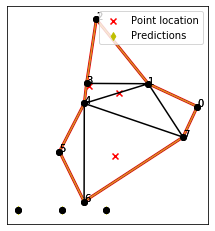

In [92]:
# Plotting the random contour using the FNN network  by predictiong the grid values

plt.clf()
for i in range(1000):
    random_contour=apply_procrustes(generate_contour(nb_of_edges))
    random_nb_of_points,random_point_coordinated_delaunay=get_extrapoints_target_length(random_contour,1,algorithm='del2d')
    if random_nb_of_points==nb_of_points:
          break
random_contour_reshaped=random_contour.reshape(1,2*nb_of_edges)
random_contour_with_target=np.hstack([random_contour_reshaped,[[1]]])

plot_contour(random_contour)
random_point_coordinated_delaunay=np.array(random_point_coordinated_delaunay)
random_point_coordinated_delaunay.reshape(nb_of_points,2)
plt.scatter(random_point_coordinated_delaunay[:,0],random_point_coordinated_delaunay[:,1],marker='x',c='r',label='Point location')





my_net=my_net.cpu()
my_net.eval()
random_grid_qualities=[]
for point in grid_points:
    random_contour_with_target_and_grid_point=np.hstack([random_contour_with_target,point.reshape(1,2)])
    random_contour_with_target_and_grid_point=Variable(torch.from_numpy(random_contour_with_target_and_grid_point))
    random_contour_with_target_and_grid_point=random_contour_with_target_and_grid_point.expand(1000,2*nb_of_edges+1+2).type(torch.FloatTensor)
    random_point_quality=my_net(random_contour_with_target_and_grid_point)
    random_point_quality=random_point_quality.data[0]
    random_point_quality=random_point_quality.numpy()

    #print(random_point_quality)
    random_grid_qualities.append(random_point_quality)

random_grid_qualities=np.array(random_grid_qualities)




label_added=False

grid_qualities_duplicate=random_grid_qualities.flatten()

predicted_points=[]
for i in range(nb_of_points):
    minimum_index=np.argmin(grid_qualities_duplicate)
    surrounding_points_index=np.array([minimum_index+1,minimum_index-1,minimum_index+nb_of_grid_points
                        ,minimum_index-nb_of_grid_points,minimum_index-nb_of_grid_points+1,minimum_index-nb_of_grid_points-1,
                        minimum_index+nb_of_grid_points+1,minimum_index+nb_of_grid_points-1])

    
    surrounding_points_index_2_ring=np.array([minimum_index+2,minimum_index-2,
                        minimum_index+2*nb_of_grid_points,
                        minimum_index+2*nb_of_grid_points+2,minimum_index+2*nb_of_grid_points-2,
                        minimum_index+2*nb_of_grid_points+1,minimum_index+2*nb_of_grid_points-1,                      
                                              
                                              
                        minimum_index-2*nb_of_grid_points,
                        minimum_index-2*nb_of_grid_points+1,minimum_index-2*nb_of_grid_points-1, 
                        minimum_index-2*nb_of_grid_points+2, minimum_index-2*nb_of_grid_points-2 ,
                                              
                        minimum_index+2,
                        minimum_index-2 ,
                        minimum_index+nb_of_grid_points+2,
                        minimum_index+nb_of_grid_points-2,
                                              
                        minimum_index-nb_of_grid_points+2,
                        minimum_index-nb_of_grid_points-2,


                                                                
                ])
    
    surrounding_points=grid_points[np.asarray(surrounding_points_index)]
    surrounding_points_2_ring=grid_points[np.asarray(surrounding_points_index_2_ring)]
    point_maximum=grid_points[minimum_index]
    if not label_added:
        plt.scatter(point_maximum[0],point_maximum[1],marker='d',s=30,c='y',label='Predictions')
        label_added=True
    plt.scatter(point_maximum[0],point_maximum[1],marker='d',s=30,c='y')
    #plt.scatter(surrounding_points[:,0],surrounding_points[:,1],marker='d',s=34)
    #plt.scatter(surrounding_points_2_ring[:,0],surrounding_points_2_ring[:,1],marker='d',s=34)
    predicted_points.append(point_maximum)
    grid_qualities_duplicate[minimum_index]=100
    grid_qualities_duplicate[np.asarray(surrounding_points_index)]=100
    #grid_qualities_duplicate[np.asarray(surrounding_points_index_2_ring)]=100
plot_contour(random_contour)
plt.legend()



def select_points(contour,grid_points,grid_qualities,nb_of_points,two_ring=True):
    
    selected_points=[]
    
    grid_qualities_duplicate=grid_qualities.flatten()
    label_added=False
    for i in range(nb_of_points):
        
        minimum_index=np.argmin(grid_qualities_duplicate)
        surrounding_points_index=np.array([minimum_index+1,minimum_index-1,minimum_index+nb_of_grid_points
                        ,minimum_index-nb_of_grid_points,minimum_index-nb_of_grid_points+1,minimum_index-nb_of_grid_points-1,
                        minimum_index+nb_of_grid_points+1,minimum_index+nb_of_grid_points-1])

    
        surrounding_points_index_2_ring=np.array([minimum_index+2,minimum_index-2,
                        minimum_index+2*nb_of_grid_points,
                        minimum_index+2*nb_of_grid_points+2,minimum_index+2*nb_of_grid_points-2,
                        minimum_index+2*nb_of_grid_points+1,minimum_index+2*nb_of_grid_points-1,                      
                                              
                                              
                        minimum_index-2*nb_of_grid_points,
                        minimum_index-2*nb_of_grid_points+1,minimum_index-2*nb_of_grid_points-1, 
                        minimum_index-2*nb_of_grid_points+2, minimum_index-2*nb_of_grid_points-2 ,
                                              
                        minimum_index+2,
                        minimum_index-2 ,
                        minimum_index+nb_of_grid_points+2,
                        minimum_index+nb_of_grid_points-2,
                                              
                        minimum_index-nb_of_grid_points+2,
                        minimum_index-nb_of_grid_points-2,


                                                                
                ])
        surrounding_points=grid_points[np.asarray(surrounding_points_index)]
        surrounding_points_2_ring=grid_points[np.asarray(surrounding_points_index_2_ring)]
        point_maximum=grid_points[minimum_index]
        #if not label_added:
         #   plt.scatter(point_maximum[0],point_maximum[1],marker='d',s=30,c='y',label='Predictions')
          #  label_added=True
        #plt.scatter(point_maximum[0],point_maximum[1],marker='d',s=30,c='y')
        selected_points.append(point_maximum)
        grid_qualities_duplicate[minimum_index]=100
        if two_ring==True:
            grid_qualities_duplicate[np.asarray(surrounding_points_index)]=100
    return np.array(selected_points)

predicted_points=np.array(predicted_points)  
random_contour_with_points=np.vstack([random_contour,predicted_points])
quality,_=quality_matrix(random_contour,predicted_points)
ordered_matrix=order_quality_matrix(quality,random_contour,random_contour_with_points,check_for_equal=True)

triangulate(random_contour,predicted_points,ordered_matrix,recursive=True)


[[[[ 1.04624993  0.05572893]
   [ 0.40388873  0.35460675]
   [ 1.04624993  0.05572893]]

  [[ 1.04624993  0.05572893]
   [ 0.40388873  0.35460675]
   [ 0.40388873  0.35460675]]

  [[ 1.04624993  0.05572893]
   [ 0.40388873  0.35460675]
   [-0.27599794  1.19920629]]

  [[ 1.04624993  0.05572893]
   [ 0.40388873  0.35460675]
   [-0.40399952  0.35870055]]

  [[ 1.04624993  0.05572893]
   [ 0.40388873  0.35460675]
   [-0.43381749  0.09673643]]

  [[ 1.04624993  0.05572893]
   [ 0.40388873  0.35460675]
   [-0.75863749 -0.53308155]]

  [[ 1.04624993  0.05572893]
   [ 0.40388873  0.35460675]
   [-0.43632664 -1.18752833]]

  [[ 1.04624993  0.05572893]
   [ 0.40388873  0.35460675]
   [ 0.85864041 -0.34436907]]

  [[ 1.04624993  0.05572893]
   [ 0.40388873  0.35460675]
   [-1.3        -1.3       ]]

  [[ 1.04624993  0.05572893]
   [ 0.40388873  0.35460675]
   [-0.72222222 -1.3       ]]

  [[ 1.04624993  0.05572893]
   [ 0.40388873  0.35460675]
   [-0.14444444 -1.3       ]]]


 [[[ 0.40388873  0.

[3, 4, 3]
[3, 4, 4]
[3, 4, 5]
[3, 4, 6]
[3, 4, 7]
[3, 4, 8]
[3, 4, 9]
[3, 4, 10]
Invalid triangulation 3 4 10
[4, 5, 0]
[4, 5, 1]
[4, 5, 2]
[4, 5, 3]
[4, 5, 4]
[4, 5, 5]
[4, 5, 6]
[4, 5, 7]
[4, 5, 8]
[4, 5, 9]
Invalid triangulation 4 5 9
[4, 5, 10]
Invalid triangulation 4 5 10
[5, 6, 0]
[5, 6, 1]
[5, 6, 2]
[5, 6, 3]
[5, 6, 4]
[5, 6, 5]
[5, 6, 6]
[5, 6, 7]
[5, 6, 8]
[5, 6, 9]
[5, 6, 10]
Invalid triangulation 5 6 10
[6, 7, 0]
[6, 7, 1]
[6, 7, 2]
[6, 7, 3]
[6, 7, 4]
[6, 7, 5]
[6, 7, 6]
[6, 7, 7]
[6, 7, 8]
Invalid triangulation 6 7 8
[6, 7, 9]
Invalid triangulation 6 7 9
[6, 7, 10]
[7, 0, 0]
[7, 0, 1]
[7, 0, 2]
[7, 0, 3]
[7, 0, 4]
[7, 0, 5]
[7, 0, 6]
[7, 0, 7]
[7, 0, 8]
Invalid triangulation 7 0 8
[7, 0, 9]
Invalid triangulation 7 0 9
[7, 0, 10]
Invalid triangulation 7 0 10
[[0.4921674  0.4162118  0.3284668  0.24698901 0.1970696  0.
  0.         0.         0.         0.         0.        ]
 [0.4921674  0.4921674  0.4921674  0.1970696  0.03171652 0.03171652
  0.         0.         0.       

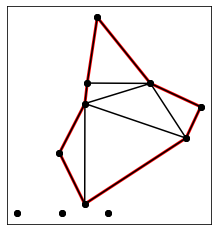

In [93]:
quality,_=quality_matrix(random_contour,predicted_points)
ordered_matrix=order_quality_matrix(quality,random_contour,random_contour_with_points,check_for_equal=True)

triangulate(random_contour,predicted_points,ordered_matrix,recursive=True)

In [94]:
random_contour,random_contour_with_points

(array([[ 1.04624993,  0.05572893],
        [ 0.40388873,  0.35460675],
        [-0.27599794,  1.19920629],
        [-0.40399952,  0.35870055],
        [-0.43381749,  0.09673643],
        [-0.75863749, -0.53308155],
        [-0.43632664, -1.18752833],
        [ 0.85864041, -0.34436907]]), array([[ 1.04624993,  0.05572893],
        [ 0.40388873,  0.35460675],
        [-0.27599794,  1.19920629],
        [-0.40399952,  0.35870055],
        [-0.43381749,  0.09673643],
        [-0.75863749, -0.53308155],
        [-0.43632664, -1.18752833],
        [ 0.85864041, -0.34436907],
        [-1.3       , -1.3       ],
        [-0.72222222, -1.3       ],
        [-0.14444444, -1.3       ]]))

In [64]:
random_contour=np.array([[ 1.34168933,  0.24611852],
       [ 0.27514834,  0.3134262 ],
       [-0.00969948,  0.42926403],
       [-0.5576541 ,  0.88749173],
       [-1.19048342,  0.16439764],
       [-0.55618151, -0.70166746],
       [ 0.06107684, -0.63333688],
       [ 0.63610401, -0.70569378]])

In [65]:
random_contour_with_points=np.array(([[ 1.34168933,  0.24611852],
        [ 0.27514834,  0.3134262 ],
        [-0.00969948,  0.42926403],
        [-0.5576541 ,  0.88749173],
        [-1.19048342,  0.16439764],
        [-0.55618151, -0.70166746],
        [ 0.06107684, -0.63333688],
        [ 0.63610401, -0.70569378],
        [ 0.61578947, -0.20526316],
        [-0.20526316, -0.34210526],
        [ 0.34210526, -0.06842105],
        [-0.61578947,  0.06842105],
        [-0.34210526, -0.06842105],
        [ 0.06842105,  0.06842105],
        [ 0.06842105, -0.20526316]]))

In [66]:
predicted_points=np.array([[ 0.61578947, -0.20526316],
       [-0.20526316, -0.34210526],
       [ 0.34210526, -0.06842105],
       [-0.61578947,  0.06842105],
       [-0.34210526, -0.06842105],
       [ 0.06842105,  0.06842105],
       [ 0.06842105, -0.20526316]])

In [21]:
quality,_=quality_matrix(random_contour,predicted_points)
ordered_matrix=order_quality_matrix(quality,random_contour,random_contour_with_points,check_for_equal=True)
triangulate(random_contour,predicted_points,ordered_matrix,recursive=True)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [5]:
plot_grid_qualities(contour,grid_qualities,grid_points,insertion_point)

NameError: name 'contour' is not defined

NameError: name 'contour' is not defined

In [ ]:
|